<a href="https://colab.research.google.com/github/carlosegn/proyecciones-ventas-alimenticias/blob/main/Proyeccion_ventas_alimenticias_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CODING DOJO: Proyecto de proyección de ventas alimenticias**
## Creado por: Carlos Guerrero

* Fecha creado: 25/03/2023
* Fecha actualización: 25/03/2023
* Descripción: Predicción de ventas para productos alimenticios vendidos en diversas tiendas con modelos de regresión lineal y árbol de regresión.

In [1]:
# Importamos librerías
import pandas as pd
import numpy as np

# Librerías de preprocesamiento
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Librerias para predicciones
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Salidas en modo texto para que se puedan ver en GitHub
from sklearn import set_config
set_config(display='text')

In [2]:
archivo = '/content/drive/MyDrive/CodingDojo/sales_predictions.csv'
df = pd.read_csv(archivo)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Exploración y limpieza de datos

In [3]:
# Limpieza de duplicados
df.duplicated().sum()

0

No existen valores duplicados

In [4]:
# Información de la base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Se observan varios registros faltantes en las variables de peso del producto (Item_Weight) y tamaño de la tienda (Outlet_Size)

In [5]:
# Analizar variable Outlet_Size
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [6]:
num_missing = df['Outlet_Size'].isna().sum()

total_rows = df.shape[0]

percent_missing = (num_missing / total_rows)*100
print(f'{percent_missing:.2f}% de los valores son nulos')

28.28% de los valores son nulos


Observamos que casi el 30% de los valores de la variable Outlet_Size son nulos, y es una variable categórica que sólo tiene 3 valores (Medium, Small o High) por lo que imputar un valor por frecuencia o con una constante ingresaría muchos errores a nuestro análisis, por lo que lo mejor es eliminar dicha columna.

In [7]:
df = df.drop(columns='Outlet_Size')
df.head(1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Tier 1,Supermarket Type1,3735.138


In [8]:
# Análisis de la variable Item_Weight
# Relación entre Item_Weight e Item_Identifier
df.groupby(['Item_Identifier'])['Item_Weight'].value_counts()

Item_Identifier  Item_Weight
DRA12            11.600         6
DRA24            19.350         5
DRA59            8.270          6
DRB01            7.390          2
DRB13            6.115          5
                               ..
NCZ30            6.590          6
NCZ41            19.850         5
NCZ42            10.500         5
NCZ53            9.600          4
NCZ54            14.650         5
Name: Item_Weight, Length: 1555, dtype: int64

In [9]:
df['Item_Identifier'].nunique()

1559

De acuerdo a los datos, todos los Item_Identifier se corresponden con un Item_Weight, por lo que podríamos imputar los valores faltantes en Item_Weight consultando los valores de Item_Identifier e imputando un valor conocido que se obtenga de otro registro, existen 1555 registros de Item_Weight agrupados por Item_Identifier vs 1559 registro de Item_Idenfier, lo que nos quiere decir que hay 4 Items que no tienen peso registrado.

In [10]:
# Obtener los Item_Identifier con valores de Item_Weight NaN
filtro_item_weight = df['Item_Weight'].isna()
df[filtro_item_weight]['Item_Identifier']

7       FDP10
18      DRI11
21      FDW12
23      FDC37
29      FDC14
        ...  
8485    DRK37
8487    DRG13
8488    NCN14
8490    FDU44
8504    NCN18
Name: Item_Identifier, Length: 1463, dtype: object

In [11]:
# Iteramos por la serie de valores que tienen un valor NaN en Item_Weight
for index, value in df[filtro_item_weight]['Item_Identifier'].iteritems():
  
  # Creamos un filtro para cada valor de Item_Identifier
  filtro_id = df['Item_Identifier'] == value

  # Guardamos el peso máximo para ese Item_Identifier, funciona con mean() o min() también ya que son valores únicos
  peso = df[filtro_id]['Item_Weight'].max()

  # Cambiamos el valor en el indice obtenido de la serie y en el atributo Item_Weight
  df.at[index, 'Item_Weight'] = peso

In [12]:
# Confirmamos si quedan valores nulos
df.isna().sum()

Item_Identifier              0
Item_Weight                  4
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Confirmamos que quedan sólo 4 registros con valores nulos lo cual confirma el análisis anterior. A estos 4 registros podemos imputar un valor de media con SimpleImputer.

In [13]:
# Revisar categorías en valores Item_Fat_Content
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [14]:
df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'}, inplace=True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Preparar los datos para aprendizaje automático

In [15]:
# El objetivo es Item_Outlet_Sales
y = df['Item_Outlet_Sales']

# En las características quitaremos las columnas de Item_Identifier y Outlet_Identifier 
# ya que sólo son identificadores de los items y las tiendas y no ayudan al análisis de predicción de ventas
X = df.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'])

In [16]:
# Realizamos un Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                6390 non-null   float64
 1   Item_Fat_Content           6392 non-null   object 
 2   Item_Visibility            6392 non-null   float64
 3   Item_Type                  6392 non-null   object 
 4   Item_MRP                   6392 non-null   float64
 5   Outlet_Establishment_Year  6392 non-null   int64  
 6   Outlet_Location_Type       6392 non-null   object 
 7   Outlet_Type                6392 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 449.4+ KB


In [18]:
# Selectores de columnas numéricas y categóricas
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [19]:
# Instanciar SimpleImputer
mean_imputer = SimpleImputer(strategy='mean')

# Instanciar OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [20]:
# Instanciar pipeline para valores numéricos
# Sólo vamos a imputar la media en los datos faltantes
numeric_pipe = make_pipeline(mean_imputer)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer())])

In [21]:
# Instanciar pipeline para valores nominales (categóricos)
# Solo codificamos con OneHotEncoder no tenemos valores a imputar
categorical_pipe = make_pipeline(ohe)
categorical_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [22]:
# Creamos tuplas que seran utilizadas por ColumnTransformer
# Cada tupla tiene el pipeline y el respectivo selector
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

# Instanciamos ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f46951adcd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f46951adbb0>)])

In [23]:
# Ajustamos con los valores de entrenamiento
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f46951adcd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f46951adbb0>)])

In [24]:
# Transformamos los datos de entrenamiento y prueba
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [27]:
# Volvemos a crear un DataFrame de Pandas
# Obtenemos los nombres de las columnas con el método get_feature_names_out de ColumnTransformer
columnas = preprocessor.get_feature_names_out()

X_train = pd.DataFrame(X_train_processed, columns=columnas)
X_test = pd.DataFrame(X_test_processed, columns=columnas)

In [31]:
# Confirmamos que tenemos de nuevo un DataFrame
X_train.head(2)

,pipeline-1__Item_Weight,pipeline-1__Item_Visibility,pipeline-1__Item_MRP,pipeline-1__Outlet_Establishment_Year,pipeline-2__Item_Fat_Content_Low Fat,pipeline-2__Item_Fat_Content_Regular,pipeline-2__Item_Type_Baking Goods,pipeline-2__Item_Type_Breads,pipeline-2__Item_Type_Breakfast,pipeline-2__Item_Type_Canned,...,pipeline-2__Item_Type_Snack Foods,pipeline-2__Item_Type_Soft Drinks,pipeline-2__Item_Type_Starchy Foods,pipeline-2__Outlet_Location_Type_Tier 1,pipeline-2__Outlet_Location_Type_Tier 2,pipeline-2__Outlet_Location_Type_Tier 3,pipeline-2__Outlet_Type_Grocery Store,pipeline-2__Outlet_Type_Supermarket Type1,pipeline-2__Outlet_Type_Supermarket Type2,pipeline-2__Outlet_Type_Supermarket Type3
0,16.35,0.029565,256.4646,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,15.25,0.000000,179.7660,2009.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [32]:
X_test.head(2)

,pipeline-1__Item_Weight,pipeline-1__Item_Visibility,pipeline-1__Item_MRP,pipeline-1__Outlet_Establishment_Year,pipeline-2__Item_Fat_Content_Low Fat,pipeline-2__Item_Fat_Content_Regular,pipeline-2__Item_Type_Baking Goods,pipeline-2__Item_Type_Breads,pipeline-2__Item_Type_Breakfast,pipeline-2__Item_Type_Canned,...,pipeline-2__Item_Type_Snack Foods,pipeline-2__Item_Type_Soft Drinks,pipeline-2__Item_Type_Starchy Foods,pipeline-2__Outlet_Location_Type_Tier 1,pipeline-2__Outlet_Location_Type_Tier 2,pipeline-2__Outlet_Location_Type_Tier 3,pipeline-2__Outlet_Type_Grocery Store,pipeline-2__Outlet_Type_Supermarket Type1,pipeline-2__Outlet_Type_Supermarket Type2,pipeline-2__Outlet_Type_Supermarket Type3
0,14.30,0.026300,79.4302,1987.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,7.93,0.071136,42.7086,1997.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
# Removemos pipeline-1__ y pipeline-2__ de los nombres de las columnas
X_train.columns = X_train.columns.str.replace('pipeline-1__', '')
X_train.columns = X_train.columns.str.replace('pipeline-2__', '')
X_test.columns = X_test.columns.str.replace('pipeline-1__', '')
X_test.columns = X_test.columns.str.replace('pipeline-2__', '')

In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      6392 non-null   float64
 1   Item_Visibility                  6392 non-null   float64
 2   Item_MRP                         6392 non-null   float64
 3   Outlet_Establishment_Year        6392 non-null   float64
 4   Item_Fat_Content_Low Fat         6392 non-null   float64
 5   Item_Fat_Content_Regular         6392 non-null   float64
 6   Item_Type_Baking Goods           6392 non-null   float64
 7   Item_Type_Breads                 6392 non-null   float64
 8   Item_Type_Breakfast              6392 non-null   float64
 9   Item_Type_Canned                 6392 non-null   float64
 10  Item_Type_Dairy                  6392 non-null   float64
 11  Item_Type_Frozen Foods           6392 non-null   float64
 12  Item_Type_Fruits and

## Predicciones con Machine Learning

### Regresión Lineal

In [41]:
# Instanciar el modelo de regresión lineal y ajustarlo a los datos de prueba
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [42]:
# Predicciones del conjunto de entrenamiento
train_preds = reg.predict(X_train)

# Predicciones del conjunto de prueba
test_preds = reg.predict(X_test)

In [43]:
# Evaluar el modelo con R^2
r2_train = r2_score(y_train, train_preds)
r2_test = r2_score(y_test, test_preds)
print("R^2 en conjunto de entrenamiento: ", r2_train)
print("R^2 en conjunto de prueba: ", r2_test)

R^2 en conjunto de entrenamiento:  0.5605554544355624
R^2 en conjunto de prueba:  0.5658838444256


In [44]:
# Evaluar el modelo con RECM
recm_train = np.sqrt(mean_squared_error(y_train, train_preds))
recm_test = np.sqrt(mean_squared_error(y_test, test_preds))
print("RECM en conjunto de entrenamiento: ", recm_train)
print("RECM en conjunto de prueba: ", recm_test)

RECM en conjunto de entrenamiento:  1140.4019761442698
RECM en conjunto de prueba:  1094.4024001708467


### Árbol de regresión

In [45]:
# Instanciar árbol de regresión con los valores por defecto
dec_tree = DecisionTreeRegressor(random_state=42)

In [46]:
# Ajustar el modelo a los datos de entrenamiento
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [53]:
# Evaluar el modelo con R^2
train_score = dec_tree.score(X_train, y_train)
test_score = dec_tree.score(X_test, y_test)
print("R^2 en conjunto de entrenamiento: ", train_score)
print("R^2 en conjunto de prueba: ", test_score)

R^2 en conjunto de entrenamiento:  0.9125253477205632
R^2 en conjunto de prueba:  0.25248464012026706


In [50]:
# Ajustar la profundidad máxima del modelo
# Obtener la profuncidad actual
dec_tree.get_depth()

40

In [57]:
# Lista de valores a probar para max_depth:
max_depth_range = list(range(2, 40))

# Lista para almacenar la puntuación para cada valor de max_depth:
r2 = []
for depth in max_depth_range:
    dec_tree = DecisionTreeRegressor(max_depth = depth, random_state = 42)
    dec_tree.fit(X_train, y_train)
    score = dec_tree.score(X_test, y_test)
    r2.append(score)

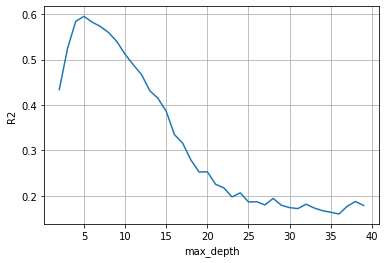

In [59]:
# Visualizar qué max_depth lleva a una puntuación R2 más alta
import matplotlib.pyplot as plt
plt.plot(max_depth_range, r2)
plt.grid()
plt.xlabel('max_depth')
plt.ylabel('R2');

In [60]:
# Ejecutar el modelo con un max_depth=5
dec_tree_5 = DecisionTreeRegressor(max_depth=5, random_state=42)
dec_tree_5.fit(X_train, y_train)
train_5_score = dec_tree_5.score(X_train, y_train)
test_5_score = dec_tree_5.score(X_test, y_test)
print("R^2 en conjunto de entrenamiento: ", train_5_score)
print("R^2 en conjunto de prueba: ", test_5_score)

R^2 en conjunto de entrenamiento:  0.6039092654846363
R^2 en conjunto de prueba:  0.5949542729674069


El valor de max_depth=5 tiene una predicción superior, por lo que será nuestro valor escogido.


In [61]:
# Evaluar el modelo con RECM con un max_depth=5
train_preds_tree = dec_tree_5.predict(X_train)
test_preds_tree = dec_tree_5.predict(X_test)
recm_train_tree = np.sqrt(mean_squared_error(y_train, train_preds_tree))
recm_test_tree = np.sqrt(mean_squared_error(y_test, test_preds_tree))
print("RECM en conjunto de entrenamiento: ", recm_train_tree)
print("RECM en conjunto de prueba: ", recm_test_tree)

RECM en conjunto de entrenamiento:  1082.6878514934986
RECM en conjunto de prueba:  1057.1243831290897


**Modelo recomendado:** recomiendo utilizar el modelo de árboles de regresión, debido a que, luego de modificar un poco sus valores por defecto los valores de las métricas de predicción son mejores en los datos de prueba, además la diferencia del RECM entre los datos de entrenamiento y de prueba es menor.

In [70]:
# Determinar la importancia de cada una de las características del modelo utilizando la propiedad feature_importances_
# Fuente: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html 
importancia = dec_tree_5.feature_importances_
for caracteristica,valor in enumerate(importancia):
	print(f'Caracteristica {caracteristica}, Importancia: {valor:.2f}')

Caracteristica 0, Importancia: 0.00
Caracteristica 1, Importancia: 0.00
Caracteristica 2, Importancia: 0.55
Caracteristica 3, Importancia: 0.03
Caracteristica 4, Importancia: 0.00
Caracteristica 5, Importancia: 0.00
Caracteristica 6, Importancia: 0.00
Caracteristica 7, Importancia: 0.00
Caracteristica 8, Importancia: 0.00
Caracteristica 9, Importancia: 0.00
Caracteristica 10, Importancia: 0.00
Caracteristica 11, Importancia: 0.00
Caracteristica 12, Importancia: 0.00
Caracteristica 13, Importancia: 0.00
Caracteristica 14, Importancia: 0.00
Caracteristica 15, Importancia: 0.00
Caracteristica 16, Importancia: 0.00
Caracteristica 17, Importancia: 0.00
Caracteristica 18, Importancia: 0.00
Caracteristica 19, Importancia: 0.00
Caracteristica 20, Importancia: 0.00
Caracteristica 21, Importancia: 0.00
Caracteristica 22, Importancia: 0.00
Caracteristica 23, Importancia: 0.00
Caracteristica 24, Importancia: 0.00
Caracteristica 25, Importancia: 0.32
Caracteristica 26, Importancia: 0.00
Caracterist

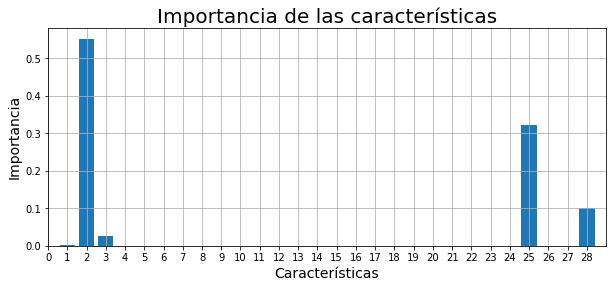

In [79]:
plt.figure(figsize=(10,4))
plt.bar([x for x in range(len(importancia))], importancia)
plt.grid()
plt.xlim(0, 29)
plt.xticks(np.arange(0, 29, step=1))
plt.title('Importancia de las características', fontsize=20)
plt.ylabel('Importancia', fontsize=14)
plt.xlabel('Características', fontsize=14)
plt.savefig('Importancia.png', dpi=300)
plt.show()

In [77]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      6392 non-null   float64
 1   Item_Visibility                  6392 non-null   float64
 2   Item_MRP                         6392 non-null   float64
 3   Outlet_Establishment_Year        6392 non-null   float64
 4   Item_Fat_Content_Low Fat         6392 non-null   float64
 5   Item_Fat_Content_Regular         6392 non-null   float64
 6   Item_Type_Baking Goods           6392 non-null   float64
 7   Item_Type_Breads                 6392 non-null   float64
 8   Item_Type_Breakfast              6392 non-null   float64
 9   Item_Type_Canned                 6392 non-null   float64
 10  Item_Type_Dairy                  6392 non-null   float64
 11  Item_Type_Frozen Foods           6392 non-null   float64
 12  Item_Type_Fruits and

**Análisis:** Podemos notar que las características 2, 25 y 28, que corresponden al Precio máximo de venta al público (Item_MRP), Tienda de comestibles (Outlet_Type_Grocery Store) y Supermercado tipo 3 (Outlet_Type_Supermarket Type3), son las que tienen una mayor importancia al momento de predecir el valor de Ventas del producto (Item_Outlet_Sales), es probable que las "Tiendas de comestibles" tengan una mayor importancia debido a que las ventas son menores, sin embargo, en este gráfico no podemos apreciar eso.